# ELECTROCARDIOGRAM - P-WAVE DETECTION
Hisham Ben Hamidane and Ludovic Le Reste

In [ ]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import signal
import time
from matplotlib.widgets import Slider

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

tf.config.list_physical_devices('GPU')
tf.test.gpu_device_name()

In [ ]:
# %% LOAD FILES
# path = "D:\Ludo\Docs\programming\CAS_applied_data_science\CAS-Applied-Data-Science-master\Module-6\Electrocardiogram_analysis\Assignments\ECG\www.physionet.org\physiobank\database".replace("\\", "/")
path = r"C:\Users\ludovic.lereste\Documents\CAS_applied_data_science\CAS-Applied-Data-Science-master\Module-6\Electrocardiogram_analysis\Assignments\ECG\www.physionet.org\physiobank\database".replace("\\", "/")
os.chdir(path)

record = wfdb.rdrecord("mitdb/100")
ann = wfdb.rdann("mitdb/100", "pwave")
atr = wfdb.rdann("mitdb/100", "atr")

record.__dict__
ann.__dict__.items()
atr.__dict__.items()

ecg = record.p_signal[:, 0]
ecg_v5 = record.p_signal[:, 1]

# translate discrete p-wave annotation into digital signal
# p-wave is +-width around annotation
p_ts = np.zeros(record.sig_len, dtype=int)
width = 6
for i in ann.sample:
    p_ts[max(i-width, 0):min(i+width, record.sig_len)] = 1
    
# translate discrete r-wave annotation into digital signal
# r-wave is +-width around annotation
r_ts = np.zeros(record.sig_len, dtype=int)
width = 6
for i in atr.sample:
    r_ts[max(i-width, 0):min(i+width, record.sig_len)] = 1

# Generate time vector
fq = 360
t = np.linspace(start=0, stop=ecg.size/fq, num=ecg.size)
tss = np.vstack((t, ecg, p_ts)).T

In [ ]:
# %% EXPLORE DATA
# # analyse heartbeats periods
# period = np.diff(atr.sample)

# # Fit a normal distribution to period distribution
# # TBD : fit can be improved (pdf vs absolute counts)
# mu, std = norm.fit(period) 
# period_mean = int(mu)
  
# # Plot the histogram and Probability Density Function.
# plt.figure()
# plt.hist(period, bins=100, density=True, alpha=0.6, color='b')
  
# x_min, x_max = plt.xlim()
# x_prob = np.linspace(x_min, x_max, 100)
# prob = norm.pdf(x_prob, period_mean, std)
  
# plt.plot(x_prob, prob, 'k', linewidth=2)
# title = f"Fit Values: {period_mean} and {std}"
# plt.title(title)
# plt.show()

# """
# N.B.:
#     There are a few (17) heartbeats with no p-wave annotated
#     There is only one weird heartbeat (lasting 407 samples: heartbeat # 1907)
# """
# print(f"There are {np.count_nonzero(period > 400)} periods longer than 400 original samples, meaning with no r-wave.")

# # Plot time series
# n_samples = period_mean*6
# heartbeats = np.where(period>00)[0]
# case = 1
# plt.figure()
# plt.plot(ecg, label='ecg')
# plt.plot(p_ts, label='p-wave')
# plt.plot(r_ts, label='r-wave')
# plt.xlim([atr.sample[heartbeats[case]-1], atr.sample[heartbeats[case]-1]+ n_samples])
# # plt.xlim([0, n_samples])
# plt.legend()
# plt.show()

# """first r-wave is wrongly labelled"""
# plt.figure()
# plt.plot(ecg, label='ecg')
# plt.plot(p_ts, label='p-wave')
# plt.plot(r_ts, label='r-wave')
# plt.xlim([0, 500])
# # plt.xlim([0, n_samples])
# plt.legend()
# plt.show()

# Fourier transform
ecg_ft = np.fft.rfft(ecg)
f = np.fft.rfftfreq(ecg.size, d=1/fq)
plt.figure()
plt.plot(f[1:], np.abs(ecg_ft[1:]))
plt.xlim([0, 60])
plt.xlabel('frequency [Hz]')
plt.title('real Fourier transform')

# Filtering frequencies
# sos = signal.butter(N=10, Wn=[fq/50000, fq/50], btype='bandpass', output='sos', fs=fq)
sos = signal.butter(N=10, Wn=30, btype='lowpass', output='sos', fs=fq)
ecg_f = signal.sosfilt(sos, ecg)
plt.figure()
plt.plot(ecg_f[:1000])
# plt.plot(ecg_v5[:1000])

# Spectrogram
plt.figure()
spec_f, spec_t, spec_map = signal.spectrogram(ecg[:20*286], fq)
plt.pcolormesh(spec_t, spec_f, spec_map, shading='gouraud', cmap='hsv')
# plt.pcolormesh(spec_t[:10], spec_f[:], spec_map[:,:10], cmap='hsv')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

In [ ]:
# %% PREP DATA
"""
Split data into packets of same length to feed to the model
The start of the chunk isi randomly chosen
remove the first (weird annotation) and the last two heartbeats (for dimension consistency)
"""
packet_length = 286
sampling = 2
packet_length_ds = ecg[: packet_length : sampling].shape[0]
ecg_packets = np.zeros(shape=(int(ecg.shape[0]/packet_length), packet_length_ds))
p_ts_packets = np.zeros(shape=ecg_packets.shape, dtype=int)

for i in range(ecg_packets.shape[0]):
    offset = np.random.randint(low=0, high=ecg.shape[0]-packet_length)
    ecg_packets[i, :] = ecg[offset : offset+packet_length : sampling]
    p_ts_packets[i, :] = p_ts[offset : offset+packet_length : sampling]

# split train, test
perc_split = 0.8
n_inputs = ecg_packets.shape[0]
ecg_packets_train = ecg_packets[0:int(n_inputs*perc_split)]
ecg_packets_test = ecg_packets[int(n_inputs*perc_split):-1]
p_ts_packets_train = p_ts_packets[0:int(n_inputs*perc_split)]
p_ts_packets_test = p_ts_packets[int(n_inputs*perc_split):-1]

In [ ]:
# %% MODEL 1: Dense neural network - simplest model
# Build model
d_mult = "single_layer"

d_input = ecg_packets.shape[1]
x = tf.keras.layers.Input(dtype='float64', shape=d_input)
   
lay_1 = tf.keras.layers.Dense(units=d_input, activation='sigmoid', name='L1')(x)

#prediction: probability->integer
# pred = 

#TBD: adding pred to the model output prudces an error (expected int64, instead had float)
model = tf.keras.Model(inputs=x, outputs=[lay_1])

model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
# %% MODEL 2: Dense neural network - more complex
# Build model
d_mult = 1.0

d_input = ecg_packets.shape[1]
x = tf.keras.layers.Input(dtype='float64', shape=d_input)

lay_1 = tf.keras.layers.Dense(units=int(d_input*d_mult), activation='relu', name='L1')(x)
lay_2 = tf.keras.layers.Dense(units=d_input, activation='sigmoid', name='L2')(lay_1)

#prediction: probability->integer
# pred = 

#TBD: adding pred to the model output prudces an error (expected int64, instead had float)
model = tf.keras.Model(inputs=x, outputs=[lay_2])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# %% MODEL 3: Convolutional neural network
"""let's try one feature map (1D-line) followed by one dense layer
and maybe try to transform the dense layer into a convolutional layer of correct size

testing:
data = tf.keras.utils.timeseries_dataset_from_array(data=tss,
                                                    targets=None,
                                                    sequence_length=300,
                                                    sequence_stride=300,
                                                    sampling_rate=1)
for el in data:
    inputs = el
    """
lay_1 = tf.keras.layers.Conv1D()
tf.keras.layers.MaxPool1D()

# %% TRAIN MODEL
batch_size = 50

start = time.time()
hist = model.fit(x=ecg_packets_train,
                    y=p_ts_packets_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(ecg_packets_test, p_ts_packets_test))
print(time.time()-start)

In [ ]:
# %% PLOT RESULTS
"""N.B.: hist.params['batch_size'] does not work on Thermo's PC"""
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[0].set_xlabel('epoch')

axs[1].plot(hist.epoch, hist.history['binary_accuracy'])
axs[1].plot(hist.epoch, hist.history['val_binary_accuracy'])
axs[1].legend(('training accuracy', 'validation accuracy'),
              title=f"batch size={batch_size}\n"
              f"validation accuracy={hist.history['val_binary_accuracy'][-1]:.3f}",
              loc='lower right')
axs[1].set_xlabel('epoch')

fig.suptitle(f"packet length = {packet_length}\n"
             f"down sampling = {sampling}\n"
             f"layer_1 dimension = {d_input}*{d_mult} = {int(d_input*d_mult)}")
plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 143)]             0         
_________________________________________________________________
L1 (Dense)                   (None, 143)               20592     
Total params: 20,592
Trainable params: 20,592
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 143)]             0         
_________________________________________________________________
L1 (Dense)                   (None, 143)               20592     
_________________________________________________________________
L2 (Dense)                   (None, 143)               20592     
Total params: 41,184
Trainable params: 4

TypeError: __init__() missing 2 required positional arguments: 'filters' and 'kernel_size'

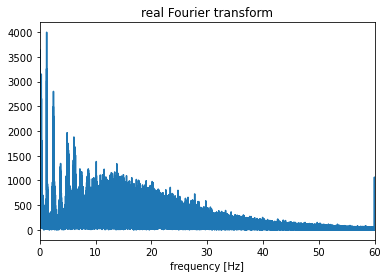

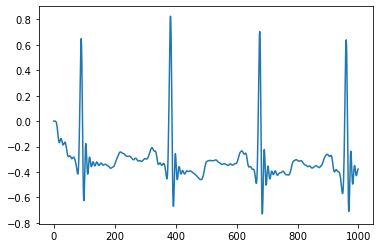

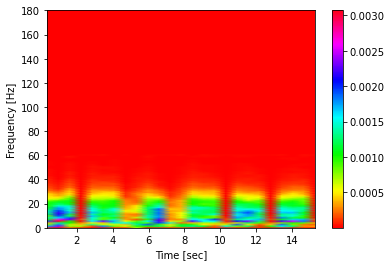

In [1]:
# %% EXAMINE RESULTS
"""N.B.: run %matplotlib auto in console"""
data = ecg_packets_test
data_ann = p_ts_packets_test
pred_test = model.predict(data)

n_rows = 4
n_cols = 6
n_plots = n_rows * n_cols
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True)
plt.get_current_fig_manager().window.state('zoomed')
plt.subplots_adjust(top=0.90)

# inititate plot lines (ls_xxx) that will later be updated by the slider
ls_data = []
ls_data_ann = []
ls_data_ann2 = []
ls_pred_test = []
for i, ax in enumerate(axs.flat):
    ls_data.append(ax.plot(data[i, :]))
    ls_data_ann.append(ax.plot(data_ann[i, :]))
    ls_data_ann2.append(ax.plot(data_ann[i, :]*-1, color='orange'))
    ls_pred_test.append(ax.plot(pred_test[i, :]))
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylim(ymin=-1.2, ymax=1.3)
plt.subplots_adjust(wspace=0, hspace=0)

ax_slider = plt.axes([0.25, 0.95, 0.65, 0.03])
slider_packet = Slider(ax=ax_slider,
                       label='Test packet',
                       valmin=0,
                       valmax=data.shape[0]-n_plots,
                       valstep=n_plots,
                       valinit=0)

def update_slider(val):
    for i in np.arange(n_plots):
        ls_data[i][0].set_ydata(data[i+val, :])
        ls_data_ann[i][0].set_ydata(data_ann[i+val, :])
        ls_data_ann2[i][0].set_ydata(data_ann[i+val, :]*-1)
        ls_pred_test[i][0].set_ydata(pred_test[i+val, :])
        
slider_packet.on_changed(update_slider)